# Folktables Exercises

The following notebook uses the folktable data found [here](https://github.com/zykls/folktables). <br>
Full 2018 ACS documentation found [here](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2018.txt). <br>
Intro to ACS public use: [video link](https://www.census.gov/data/academy/webinars/2020/introduction-to-american-community-survey-public-use-microdata-sample-pums-files.html).

### Definitions:

**ACS (American Community Survey)** - Information from the survey generates data that help determine how more than $675 billion in federal and state funds are distributed each year. Unlike the every-10-year census, this survey continues all year, every year. ACS randomly samples addresses in every state, the District of Columbia, and Puerto Rico. 

**ACSEmployment data**

<code> features </code> **- the independent variables**
* ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']
| Feature      | Description                   |
| :---         | :---                          |
| AGEP         | Age                           |
| SCHL         | Educational attainment        |
| Mar          | Marital status                |
| RELP         | Relationship                  |
| DIS          | Disability recode             |
| ESP          | Employment status of parents  |
| CIT          | Citizenship status            |
| MIG          | Mobility status (lived here 1 year ago)|
| MIL          | Military service              |
| ANC          | Ancestry recode               |
| NATIVITY     | Native or Foreign born        |
| DEAR         | Hearing difficulty            |
| DEYE         | Vision difficulty             |
| DREM         | Cognitive difficulty          |
| SEX          | Male or Female                |
| RAC1P        | Recoded detailed race code    |


       
<code> group </code> **- race group**
* 1    .White alone
* 2    .Black or African American alone
* 3    .American Indian alone
* 4    .Alaska Native alone
* 5    .American Indian and Alaska Native tribes specified; or American   Indian or Alaska Native, not specified and no other races
* 6    .Asian alone
* 7    .Native Hawaiian and Other Pacific Islander alone
* 8    .Some Other Race alone
* 9    .Two or More Races

<code>nav_group </code> **- native group**
* 1    .Native
* 2    .Foreign born

<code>sex_group </code> **- sex group**
* 1    .Male
* 2    .Female

<code> labels </code> **- Employment status recode**
* b    .N/A (less than 16 years old)
* 1    .Civilian employed, at work
* 2    .Civilian employed, with a job but not at work
* 3    .Unemployed
* 4    .Armed forces, at work
* 5    .Armed forces, with a job but not at work
* 6    .Not in labor force

<code>cont_labels </code> **- Wages & income**
* **NOTE:** There are some NaN values present in this 2018 CA dataset.

---
**NOTE:** This a personal documentation of what I have learned from fairlearn since 9/11/2022.
### fairlearn packages:

**datasets** - fetch sample datasets 

**metrics** - functionality for computing metrics with a focus on ‘disaggregated metrics’. This is a metric where in addition to y_true and y_pred values, the user provides information about group membership for each sample. 

**postprocessing** - methods which operate on the predictor (i.e. X) rather than the estimator (i.e. Y). 

**preprocessing**  - a filtering technique that eliminates sensitive correlations in the dataset. 

**reductions** - This module contains algorithms implementing the reductions approach to disparity mitigation. In this approach, disparity constraints are cast as Lagrange multipliers, which cause the reweighting and relabelling of the input data. This reduces the problem back to standard machine learning training.

### fairlearn can and can’t:
**can -**
* **Fairness Assessments** [link](https://fairlearn.org/main/user_guide/assessment.html)
* **Demographic Parity** - a fairness metric whose goal is to ensure a machine learning model’s predictions are independent of membership in a sensitive group. $$E[h(X)|A=a]=E[h(X)], \forall a$$
$$P[f(X) \leq z|A=a]=P[f(X)\leq z],  \forall a, z$$ where $A$ is a sensitive feature, $h$ is a classifier, and $f$ is a regressor.<br>
<code>demographic_parity_difference()</code>  - Returns the absolute difference between the highest and lowest selection rates of the sensitive groups. A result of 0 means there is a demographic parity. (only for classifiers). <br>
<code>demographic_parity_ratio()</code> - Returns the ratio of the lowest and highest selection rates. A result of 1 means there is a demographic parity.
* **Equalized Odds** - The goal of the equalized odds fairness metric is to ensure a machine learning model performs equally well for different groups. It is stricter than demographic parity because it requires that the machine learning model’s predictions are not only independent of sensitive group membership, but that groups have the same false positive rates and true positive rates. $$E[h(X)|A=a, Y=y]=E[h(X)|Y=y],  \forall a, y$$ AND 
that the true positive rate and false positive rate be equal across groups (classifiers). <br>
<code>equalized_odds_difference()</code> - Returns the largest difference between the TRP difference and FPR difference. <br>
<code>equalized_odds_ratio()</code> - Returns the the smallest ratio between the TRP ratio and FPR ratio. 
* **Equal Opportunity** - Equal opportunity is a relaxed version of equalized odds that only considers conditional expectations with respect to positive labels. NOTE: The developers of fairlearn suggest that this fairness metric can overlook misclassifications since it does not consider false positive rates.
* **Intersecting Groups** - Fairlearn supports metric assessment in the scenario of intersection of multiple sensitive features. <br>
<code>MetricFrame.by_group</code> - Returns a table that displays all the possible combinations of sensitive groups and their fairness metric results.
* **Control Feature**
* **Group by Group Visualizations**
* **Unfairness Mitigations** - algorithm related techniques to mitigate unfairness. Full list of algorithms and their basic descriptions found here.
---
* **Fairness Mitigation** [link](https://fairlearn.org/main/user_guide/mitigation.html)
* <code>ExponentiatedGradient</code>
* <code>GridSearch</code>
* <code>ThresholdOptimizer</code>
* <code>CorrelationRemover</code>

**can’t -** 
* Fairly limited in number of postprocessing and preprocessing techniques. Most of the assessment tools that fairlearn offers inherit from the ‘metrics’ package.
* I have yet to find a focus on unsupervised related techniques.

In [75]:
import pandas as pd
import numpy as np
from folktables import ACSDataSource, ACSEmployment
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, \
                              false_positive_rate, \
                              selection_rate

**NOTE:**The following exercise deals with trying different fairness metrics, and mitigation techniques with classifers.

In [239]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

# create sensitive feature(s):
nat_group = acs_data["NATIVITY"]
sex_group = acs_data["SEX"]

In [101]:
# identifying encodings
race = {
    1: "White alone",
    2: "Black or African American alone",
    3: "American Indian alone",
    4: "American Indian alone",
    5: "American Indian/Alaska Native specified/not specified or no other races", # truncated for index purposes
    6: "Asian alone",
    7: "Native Hawaiian and Other Pacific Islander alone",
    8: "Some Other Race alone",
    9: "Two or More Races"
}

In [170]:
# create a standard scaler for the data
scaler = StandardScaler().fit(features)
#scaler_cont = StandardScaler().fit(np.array(cont_labels).reshape(-1, 1))

In [174]:
X_train, X_test, y_train, y_test, cont_train, cont_test, group_train, group_test, sex_train, sex_test, nat_train, nat_test = train_test_split(
    features, label, cont_labels, group, sex_group, nat_group, test_size=0.2, random_state=0)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

###### Your favorite LINEAR learning algorithm here #####
model = LogisticRegression()
model.fit(X_train, y_train)

yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print("Linear Model Accuracy is:", accuracy)

white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

# Equality of opportunity violation: 0.0455
white_tpr - black_tpr

Linear Model Accuracy is: 0.7728736603136054


0.04549392964278809

## ---fairlearn library: linear---
## Metrics

In [7]:
# Construct a function dictionary
my_metrics = {
    'accuracy' : accuracy_score,
    'tpr' : recall_score,
    'fpr' : false_positive_rate,
    'sel' : selection_rate,
    'count' : count
}
# Construct a MetricFrame
mf = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=yhat,
    sensitive_features={"Race":group_test}
)

In [8]:
# overall True Positive Rate, False Positive Rate, Selection Rate, Counts
mf.overall

accuracy    0.772874
tpr         0.833304
fpr         0.277458
sel         0.530041
count          75764
dtype: object

In [9]:
# by group analysis
linear_results = mf.by_group.rename(index=race)
linear_results

,accuracy,tpr,fpr,sel,count
Race,,,,,
White alone,0.774938,0.825167,0.266918,0.520662,46245
Black or African American alone,0.769168,0.779673,0.237753,0.452994,3691
American Indian alone,0.76225,0.798077,0.259475,0.462795,551
American Indian alone,0.5,0.5,0.5,0.5,4
American Indian/Alaska Native specified/not specified or no other races,0.69375,0.658228,0.271605,0.4625,160
Asian alone,0.757683,0.887422,0.37091,0.62802,12170
Native Hawaiian and Other Pacific Islander alone,0.706897,0.782178,0.351145,0.538793,232
Some Other Race alone,0.765173,0.810706,0.273517,0.520286,8947
Two or More Races,0.827843,0.863439,0.192857,0.439426,3764


### Demographic Parity

In [10]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import demographic_parity_ratio

In [11]:
diff_dem = demographic_parity_difference(y_test, yhat, sensitive_features=group_test)
print("The Demographic Parity Difference is:", diff_dem)

The Demographic Parity Difference is: 0.1885935782227861


In [12]:
ratio_dem = demographic_parity_ratio(y_test, yhat, sensitive_features=group_test)
print("The Demographic Parity Ratio is:", ratio_dem)

The Demographic Parity Ratio is: 0.6997011844862872


**Result(s):**
* A **demographic parity difference (DPD)** of 0 is what constitutes the presence of a demographic parity. For the race DPD, a result of 0.18859 means that a perfect demographic parity has not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the DPD - asian alone and 2+ more races.
* A **demographic parity ratio (DPR)** of 1 is what constitutes the presence of a demographic parity. For the race DPR, a result of 0.6997 means that a perfect demographic parity has not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the DPR - asian alone and 2+ more races.

### Equalized Odds

In [13]:
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import equalized_odds_ratio

In [14]:
diff_EO = equalized_odds_difference(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Difference is:", diff_EO)

The Equalized Odds Difference is: 0.38742159128425224


In [15]:
ratio_EO = equalized_odds_ratio(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Ratio is:", ratio_EO)

The Equalized Odds Ratio is: 0.38571428571428573


**Result(s):**
* A **equalized odds difference (EOD)** of 0 is what constitutes the presence of equalized odds. For the race EOD, a result of 0.3874 means that perfect equalized odds have not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the EOD - alaska native and asian alone. NOTE: The alaska native alone group only contains 4 entries.
* A **equalized odds ratio (EOR)** of 1 is what constitutes the presence of equalized odds. For the race EOR, a result of 0.3857 means that perfect equalized odds have not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the EOR - alaska native and asian alone. NOTE: The alaska native alone group only contains 4 entries.

### Intersecting Groups

In [16]:
s_f_frame = {
    "Race": group_test,
    "Sex": sex_test
}

metric_2sf = MetricFrame(metrics=my_metrics,
                         y_true=y_test,
                         y_pred=yhat,
                         sensitive_features=s_f_frame)

In [17]:
metric_2sf.by_group

accuracy       tpr       fpr       sel  count
Race Sex                                               
1    1    0.789591  0.863236  0.282498  0.569766  22941
     2    0.760513    0.7805  0.253668  0.472322  23304
2    1    0.764063  0.843615  0.284832  0.497542   1831
     2    0.774194  0.721717  0.188818   0.40914   1860
3    1    0.798535  0.893204  0.258824  0.498168    273
     2    0.726619  0.704762  0.260116  0.428058    278
4    1           1         1         0         1      1
     2    0.333333         0       0.5  0.333333      3
5    1    0.740741  0.790698  0.315789  0.567901     81
     2     0.64557       0.5  0.232558   0.35443     79
6    1     0.78045  0.930757  0.391384  0.679093   5821
     2    0.736809  0.841856  0.354535  0.581194   6349
7    1    0.713043  0.849057  0.403226  0.608696    115
     2    0.700855  0.708333  0.304348  0.470085    117
8    1    0.809064  0.857268  0.241921  0.558223   4457
     2    0.721604  0.752062  0.299139  0.482628   4490
9    1    0.838969  0.907381  0.201365  0.463231   1863
     2    0.816938  0.819625  0.184603  0.416097   1901

## Reductions: ThresholdOptimizer

In [18]:
from fairlearn.postprocessing import ThresholdOptimizer

In [ ]:
# define sensitive features in terms of train-test sets
sf_train = pd.DataFrame(data={
    "group_train" : group_train,
    "nat_train" : nat_train,
    "sex_train" : sex_train})
sf_test = pd.DataFrame(data={
    "group_test" : group_test,
    "nat_test" : nat_test,
    "sex_test" : sex_test})

In [129]:
# implementing fairlearn model optimizer
fair_model = LogisticRegression()
unmitigated_lr = fair_model.fit(X_train, y_train)

# define the constraint - example: demographic parity
# define the objective - example: balanced accuracy score
postprocess_est = ThresholdOptimizer(
                   estimator=unmitigated_lr,
                   constraints="demographic_parity",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='predict_proba') 

postprocess_est.fit(X_train, y_train, sensitive_features=sf_train)

yhat = postprocess_est.predict(X_test, sensitive_features=sf_test)

accuracy = accuracy_score(y_test, yhat)
print("The fairML model accuracy for Logistic Regression is:", accuracy)

The fairML model accuracy for Logistic Regression is: 0.76146982735864


In [130]:
# check demographic parity post fairML model
diff_fair_dem = demographic_parity_difference(y_test, yhat, sensitive_features=sf_test)
print("The Demographic Parity Difference is:", diff_fair_dem)

Found 36 subgroups. Evaluation may be slow


The Demographic Parity Difference is: 0.7096774193548387


In [131]:
# check demographic parity post fairML model
ratio_fair_dem = demographic_parity_ratio(y_test, yhat, sensitive_features=group_test)
print("The Demographic Parity Ratio is:", ratio_fair_dem)

The Demographic Parity Ratio is: 0.4166666666666667


In [22]:
# Construct a MetricFrame
mf_threshold = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=yhat,
    sensitive_features={"Race":group_test}
)

linear_fairML_results_dem = mf_threshold.by_group.rename(index=race)
linear_fairML_results_dem

,accuracy,tpr,fpr,sel,count
Race,,,,,
White alone,0.772213,0.862131,0.302716,0.55699,46245
Black or African American alone,0.748036,0.88131,0.339775,0.554863,3691
American Indian alone,0.736842,0.865385,0.341108,0.53902,551
American Indian alone,0.5,0.5,0.5,0.5,4
American Indian/Alaska Native specified/not specified or no other races,0.69375,0.797468,0.407407,0.6,160
Asian alone,0.758833,0.824034,0.305792,0.563763,12170
Native Hawaiian and Other Pacific Islander alone,0.706897,0.792079,0.358779,0.547414,232
Some Other Race alone,0.765955,0.863747,0.317139,0.568235,8947
Two or More Races,0.792242,0.983382,0.318908,0.563231,3764


In [132]:
mf_threshold = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=yhat,
    sensitive_features=sf_test
)

Found 36 subgroups. Evaluation may be slow


In [142]:
mf_threshold.by_group

accuracy       tpr       fpr       sel  count
group_test nat_test sex_test                                               
1          1        1         0.797826  0.852981  0.249033  0.526448  19132
                    2         0.766601  0.856505  0.295523  0.524758  19186
           2        1         0.703334  0.678516  0.245797  0.536624   3809
                    2         0.683827  0.751092  0.370079  0.539582   4118
2          1        1         0.732703  0.884488  0.352074  0.542874   1691
                    2         0.759627  0.849635  0.300292  0.519837   1714
           2        1         0.757143  0.758242  0.244898  0.578571    140
                    2         0.684932  0.619048  0.225806  0.452055    146
3          1        1         0.767442  0.946809  0.335366   0.55814    258
                    2         0.693548  0.808989  0.371069  0.528226    248
           2        1              0.8  0.666667         0       0.4     15
                    2         0.633333     0.625  0.357143       0.5     30
4          1        1              NaN       NaN       NaN       NaN    NaN
                    2         0.333333         0       0.5  0.333333      3
           2        1                0         0         0         0      1
                    2              NaN       NaN       NaN       NaN    NaN
5          1        1         0.703125   0.83871  0.424242     0.625     64
                    2         0.676923  0.851852  0.447368  0.615385     65
           2        1         0.764706      0.75       0.2  0.588235     17
                    2         0.357143  0.333333       0.6  0.428571     14
6          1        1         0.822185  0.975815  0.281361  0.560965   2362
                    2         0.806979   0.94378  0.273109   0.52076   2264
           2        1         0.740387  0.707057  0.204598  0.517491   3459
                    2         0.693023  0.725555  0.341972  0.540759   4085
7          1        1         0.690476  0.787879  0.372549  0.535714     84
                    2         0.710526       0.8  0.347826  0.526316     76
           2        1         0.806452       0.9  0.363636  0.709677     31
                    2         0.731707  0.722222   0.26087  0.463415     41
8          1        1         0.822065  0.952336  0.261108  0.530461   2692
                    2         0.782543  0.960486  0.324029  0.562429   2635
           2        1         0.709915  0.674718  0.206501  0.535977   1765
                    2         0.617251  0.675481  0.430108  0.540162   1855
9          1        1         0.805623  0.989051  0.286765  0.522005   1636
                    2         0.794171  0.980496  0.302862  0.534912   1647
           2        1         0.700441  0.699301  0.297619  0.550661    227
                    2         0.720472   0.79845      0.36  0.582677    254

In [23]:
# implementing fairlearn model optimizer
fair_model = LogisticRegression()
unmitigated_lr = fair_model.fit(X_train, y_train)

# define the constraint - example: demographic parity
# define the objective - example: balanced accuracy score
postprocess_est = ThresholdOptimizer(
                   estimator=unmitigated_lr,
                   constraints="equalized_odds",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='predict_proba') 

postprocess_est.fit(X_train, y_train, sensitive_features=group_train)

yhat = postprocess_est.predict(X_test, sensitive_features=group_test)

accuracy = accuracy_score(y_test, yhat)
print("The fairML model accuracy for Logistic Regression is:", accuracy)

The fairML model accuracy for Logistic Regression is: 0.7395596853386833


In [24]:
# check equalized odds parity post fairML model
diff_fair_EO = equalized_odds_difference(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Difference is:", diff_fair_dem)

The Equalized Odds Difference is: 0.09999999999999998


In [25]:
# check equalized odds post fairML model
ratio_fair_EO = equalized_odds_ratio(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Ratio is:", ratio_fair_EO)

The Equalized Odds Ratio is: 0.381123595505618


In [26]:
# Construct a MetricFrame
mf_threshold = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=yhat,
    sensitive_features={"Race":group_test}
)

linear_fairML_results_EO = mf_threshold.by_group.rename(index=race)
linear_fairML_results_EO

,accuracy,tpr,fpr,sel,count
Race,,,,,
White alone,0.741399,0.907326,0.396868,0.62889,46245
Black or African American alone,0.735844,0.91337,0.381124,0.592522,3691
American Indian alone,0.704174,0.899038,0.413994,0.597096,551
American Indian alone,0.25,0.5,1,0.75,4
American Indian/Alaska Native specified/not specified or no other races,0.6875,0.860759,0.481481,0.66875,160
Asian alone,0.755382,0.907395,0.395288,0.650205,12170
Native Hawaiian and Other Pacific Islander alone,0.711207,0.881188,0.419847,0.62069,232
Some Other Race alone,0.727059,0.901217,0.420922,0.641556,8947
Two or More Races,0.70882,0.899566,0.402101,0.585016,3764


## ---fairlearn library: non-linear---

In [27]:
###### Your favorite NON-LINEAR learning algorithm here #####
model = RandomForestClassifier()
model.fit(X_train, y_train)

yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print("Non-Linear Model Accuracy is:", accuracy)

white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])

# Equality of opportunity violation: 0.0211
white_tpr - black_tpr

Non-Linear Model Accuracy is: 0.8011852594899952


0.0185629096176837

In [28]:
# Construct a MetricFrame
mf = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=yhat,
    sensitive_features=group_test
)

In [29]:
# overall True Positive Rate, False Positive Rate, Selection Rate, Counts
mf.overall

accuracy    0.801185
tpr         0.812943
fpr         0.208608
sel         0.483224
count          75764
dtype: object

In [30]:
# by group analysis
RF_results = mf.by_group.rename(index=race)

### Demographic Parity

In [31]:
diff_RF_dem = demographic_parity_difference(y_test, yhat, sensitive_features=group_test)
print("The Demographic Parity Difference is:", diff_RF_dem)

The Demographic Parity Difference is: 0.359192348565356


In [32]:
ratio_RF_dem = demographic_parity_ratio(y_test, yhat, sensitive_features=group_test)
print("The Demographic Parity Ratio is:", ratio_RF_dem)

The Demographic Parity Ratio is: 0.5210768685795254


**Result(s):**
* A **demographic parity difference (DPD)** of 0 is what constitutes the presence of a demographic parity. For the race DPD, a result of 0.3594 means that a perfect demographic parity has not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the DPD - alaskan native and 2+ more races.
* A **demographic parity ratio (DPR)** of 1 is what constitutes the presence of a demographic parity. For the race DPR, a result of 0.5207 means that a perfect demographic parity has not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the DPR - alaskan native and 2+ more races.

NOTE: The alaska native alone group only contains 4 entries.

### Equalized Odds

In [33]:
diff_RF_EO = equalized_odds_difference(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Difference is:", diff_RF_EO)

The Equalized Odds Difference is: 0.35672268907563026


In [34]:
ratio_RF_EO = equalized_odds_ratio(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Ratio is:", ratio_RF_EO)

The Equalized Odds Ratio is: 0.2865546218487395


**Result(s):**
* A **equalized odds difference (EOD)** of 0 is what constitutes the presence of equalized odds. For the race EOD, a result of 0.3575 means that perfect equalized odds have not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the EOD - alaska native and 2+ more races. 
* A **equalized odds ratio (EOR)** of 1 is what constitutes the presence of equalized odds. For the race EOR, a result of 0.2848 means that perfect equalized odds have not been achieved. If we take a look at the by group analysis we can see which race selection rates were used to calculate the EOR - alaska native and 2+ more races.

NOTE: The alaska native alone group only contains 4 entries.

### Intersecting Groups

In [35]:
metric_2sf = MetricFrame(metrics=my_metrics,
                         y_true=y_test,
                         y_pred=yhat,
                         sensitive_features=s_f_frame)

In [36]:
metric_2sf.by_group

accuracy       tpr       fpr       sel  count
Race Sex                                               
1    1    0.830609  0.852044  0.190374  0.517676  22941
     2    0.772786  0.761787   0.21941  0.444516  23304
2    1    0.832878  0.824964  0.162257  0.414528   1831
     2    0.782796  0.762029  0.202566  0.433871   1860
3    1    0.820513  0.834951  0.188235  0.432234    273
     2     0.71223  0.685714  0.271676  0.428058    278
4    1           1         1         0         1      1
     2    0.666667         1       0.5  0.666667      3
5    1    0.839506  0.813953  0.131579  0.493827     81
     2    0.734177      0.75   0.27907  0.493671     79
6    1    0.835595  0.876329  0.210972  0.565882   5821
     2    0.757915  0.780562  0.261779  0.503071   6349
7    1    0.808696   0.90566  0.274194  0.565217    115
     2    0.752137  0.791667  0.275362  0.487179    117
8    1    0.848328  0.883893  0.189289  0.546332   4457
     2    0.734521  0.715228   0.25234  0.439866   4490
9    1    0.869028  0.863965  0.127986  0.400966   1863
     2     0.81536   0.76912  0.158113  0.380852   1901

## Reductions: ThresholdOptimizer

In [37]:
# implementing fairlearn model optimizer
fair_model = RandomForestClassifier()
unmitigated_rf = fair_model.fit(X_train, y_train)

# define the constraint - example: demographic parity
# define the objective - example: balanced accuracy score
postprocess_est = ThresholdOptimizer(
                   estimator=unmitigated_rf,
                   constraints="demographic_parity",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='predict_proba') 

postprocess_est.fit(X_train, y_train, sensitive_features=group_train)

yhat = postprocess_est.predict(X_test, sensitive_features=group_test)

accuracy = accuracy_score(y_test, yhat)
print("The fairML model accuracy for Random Forest is:", accuracy)

The fairML model accuracy for Random Forest is: 0.7960112982419091


In [38]:
# check demographic parity post fairML model
diff_fairRF_dem = demographic_parity_difference(y_test, yhat, sensitive_features=group_test)
print("The Demographic Parity Difference is:", diff_fairRF_dem)

The Demographic Parity Difference is: 0.5189101524489135


In [39]:
# check demographic parity post fairML model
ratio_fairRF_dem = demographic_parity_ratio(y_test, yhat, sensitive_features=group_test)
print("The Demographic Parity Ratio is:", ratio_fairRF_dem)

The Demographic Parity Ratio is: 0.4810898475510866


In [40]:
# Construct a MetricFrame
mf_threshold = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=yhat,
    sensitive_features={"Race":group_test}
)

RF_fairML_results_dem = mf.by_group.rename(index=race)
RF_fairML_results_dem

,accuracy,tpr,fpr,sel,count
sensitive_feature_0,,,,,
White alone,0.80147,0.810514,0.206065,0.480809,46245
Black or African American alone,0.80764,0.791951,0.182022,0.424275,3691
American Indian alone,0.76588,0.759615,0.230321,0.430127,551
American Indian alone,0.75,1,0.5,0.75,4
American Indian/Alaska Native specified/not specified or no other races,0.7875,0.78481,0.209877,0.49375,160
Asian alone,0.79507,0.829647,0.239202,0.533114,12170
Native Hawaiian and Other Pacific Islander alone,0.780172,0.851485,0.274809,0.525862,232
Some Other Race alone,0.791215,0.809246,0.224106,0.492903,8947
Two or More Races,0.841923,0.816474,0.143277,0.390808,3764


In [41]:
# implementing fairlearn model optimizer
fair_model = RandomForestClassifier()
unmitigated_rf = fair_model.fit(X_train, y_train)

# define the constraint - example: demographic parity
# define the objective - example: balanced accuracy score
postprocess_est = ThresholdOptimizer(
                   estimator=unmitigated_rf,
                   constraints="demographic_parity",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='predict_proba') 

postprocess_est.fit(X_train, y_train, sensitive_features=group_train)

yhat = postprocess_est.predict(X_test, sensitive_features=group_test)

accuracy = accuracy_score(y_test, yhat)
print("The fairML model accuracy for Random Forest is:", accuracy)

The fairML model accuracy for Random Forest is: 0.7963412702602819


In [42]:
# check demographic parity post fairML model
diff_fairRF_EO = equalized_odds_difference(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Difference is:", diff_fairRF_EO)

The Equalized Odds Difference is: 0.7977748691099477


In [43]:
# check demographic parity post fairML model
ratio_fairRF_EO = equalized_odds_ratio(y_test, yhat, sensitive_features=group_test)
print("The Equalized Odds Ratio is:", ratio_fairRF_EO)

The Equalized Odds Ratio is: 0.20222513089005237


In [44]:
# Construct a MetricFrame
mf_threshold = MetricFrame(
    metrics=my_metrics,
    y_true=y_test,
    y_pred=yhat,
    sensitive_features={"Race":group_test}
)

RF_fairML_results_EO = mf_threshold.by_group.rename(index=race)
RF_fairML_results_EO

,accuracy,tpr,fpr,sel,count
Race,,,,,
White alone,0.800216,0.808088,0.206343,0.479857,46245
Black or African American alone,0.791114,0.937926,0.305618,0.55676,3691
American Indian alone,0.738657,0.918269,0.370262,0.577132,551
American Indian alone,0.5,1,1,1,4
American Indian/Alaska Native specified/not specified or no other races,0.7375,0.886076,0.407407,0.64375,160
Asian alone,0.78143,0.764939,0.202225,0.482334,12170
Native Hawaiian and Other Pacific Islander alone,0.775862,0.930693,0.343511,0.599138,232
Some Other Race alone,0.795574,0.827494,0.231548,0.505309,8947
Two or More Races,0.816419,0.971098,0.273529,0.530021,3764


## ---Visualizing Results---

In [45]:
import matplotlib.pyplot as plt

In [47]:
## Order of Results:
##
## 1. linear_results
## 2. linear_fairML_results_dem
## 3. RF_results
## 4. RF_fairML_results_dem
s = "American Indian alone"
dem1 = linear_results.drop([s])["sel"].max() - linear_results.drop([s])["sel"].min()
dem2 = linear_fairML_results_dem.drop([s])["sel"].max() - linear_fairML_results_dem.drop([s])["sel"].min()
dem3 = RF_results.drop([s])["sel"].max() - RF_results.drop([s])["sel"].min()
dem4 = RF_fairML_results_dem.drop([s])["sel"].max() - RF_fairML_results_dem.drop([s])["sel"].min()

EO1 = linear_results.drop([s])["sel"].max() - linear_results.drop([s])["sel"].min()
EO2 = linear_fairML_results_EO.drop([s])["sel"].max() - linear_fairML_results_EO.drop([s])["sel"].min()
EO3 = RF_results.drop([s])["sel"].max() - RF_results.drop([s])["sel"].min()
EO4 = RF_fairML_results_EO.drop([s])["sel"].max() - RF_fairML_results_EO.drop([s])["sel"].min()

dem_diffs = {
    "Linear"       : dem1,
    "LinearFairML" : dem2,
    "RF"           : dem3,
    "RFFairML"     : dem4
}

EO_diffs = {
    "Linear"       : EO1,
    "LinearFairML" : EO2,
    "RF"           : EO3,
    "RFFairML"     : EO4
}

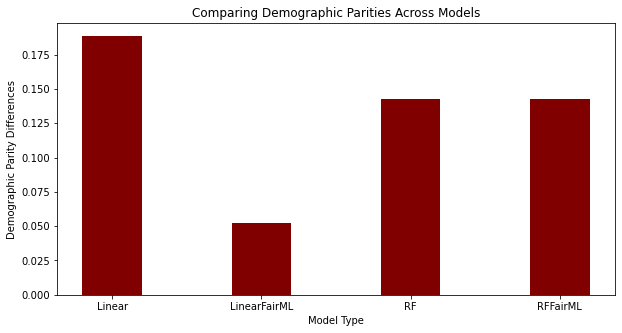

In [48]:
fig = plt.figure(figsize = (10, 5))
 

# creating the bar plot
plt.bar(dem_diffs.keys(), dem_diffs.values(), color ='maroon',
        width = 0.4)
 
plt.xlabel("Model Type")
plt.ylabel("Demographic Parity Differences")
plt.title("Comparing Demographic Parities Across Models")
plt.show()

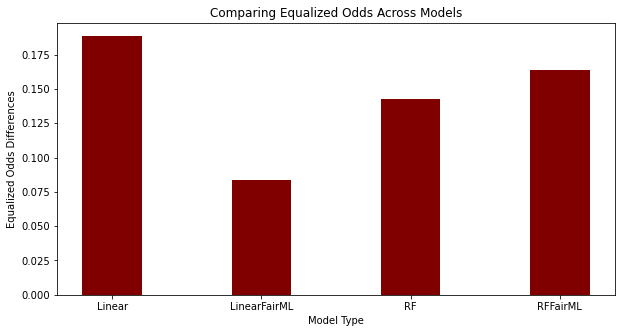

In [49]:
fig = plt.figure(figsize = (10, 5))
 

# creating the bar plot
plt.bar(EO_diffs.keys(), EO_diffs.values(), color ='maroon',
        width = 0.4)
 
plt.xlabel("Model Type")
plt.ylabel("Equalized Odds Differences")
plt.title("Comparing Equalized Odds Across Models")
plt.show()

---

# Changing the target variable to a continuous value and exploring fairness within regression:
The progress of this section has been moved to a separate notebook.

In [340]:
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from sklearn.preprocessing import MinMaxScaler
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss

In [371]:
# drop null values: there are 63086 NaN values
cont_labels = acs_data["WAGP"]

t = pd.DataFrame(np.hstack((features, np.array(cont_labels).reshape(-1, 1)))).dropna()
cont_features, cont_labels, cont_group = t.iloc[:, 0:16], t.iloc[:,16], t[15]

In [374]:
# standerdize the data
scaler = MinMaxScaler().fit(cont_features)
scaler_cont = MinMaxScaler().fit(np.array(cont_labels).reshape(-1, 1))

In [375]:
# create train and test sets
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    cont_features, cont_labels, cont_group, test_size=0.2, random_state=0)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler_cont.transform(np.array(y_train).reshape(-1, 1))
y_test = scaler_cont.transform(np.array(y_test).reshape(-1, 1))

In [376]:
# train a simple liner regressor and evaluate
linear = LinearRegression()
linear.fit(X_train, y_train)

yhat = linear.predict(X_test)
linear_MAE = mean_absolute_error(y_test, yhat)
print("Linear Model MAE is:", linear_MAE)

Linear Model MAE is: 0.06262536327522135


In [406]:
# train a Random Forest regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

yhat = rf.predict(X_test)
rf_MAE = mean_absolute_error(y_test, yhat)
print("RF Model MAE is:", rf_MAE)

<ipython-input-406-1212f19eaa3e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RF Model MAE is: 0.052219985706353896


## fairness in-processing: ExponentiatedGradient

In [383]:
# initialize the ExponentiatedGradient
sweep = GridSearch(LinearRegression(),
                  constraints=BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1),
                  grid_size=4)

In [384]:
# fit the in-processor
sweep.fit(X_train, y_train,
          sensitive_features=group_train.rename("race"))

predictors = sweep.predictors_

The grid has 8 dimensions. It is not recommended to use more than 4, otherwise a prohibitively large grid size is required to explore the space thoroughly. For such cases consider using ExponentiatedGradient from the fairlearn.reductions module.
Generating a grid with 4 grid points. It is recommended to use at least 256 grid points. Please consider increasing grid_size.


In [403]:
fairML_errors, fairML_disparities, t1 = [], [], []
for m in predictors:
    def classifier(X): return m.predict(X)
    
    m.fit(X_train, y_train)

    yhat = m.predict(X_test)
    m_MAE = mean_absolute_error(y_test, yhat)
    fairML_errors.append(m_MAE)
    
    # evaluate disparities
    #mae_frame = MetricFrame(metrics=mean_absolute_error,
    #                    y_true=y_test,
    #                    y_pred=yhat,
    #                    sensitive_features=group_test.rename("race"))
    
    bgl = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
    bgl.load_data(X_test, y_test, sensitive_features=group_test.rename("race"))
    fairML_disparities.append(bgl.gamma(lambda X: yhat))
    
    # ---
    #bgl = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
    #bgl.load_data(X_test, y_test, sensitive_features=group_test.rename("race"))
    #t1.append(bgl.gamma(lambda X: yhat))
    
    #error = ErrorRate()
    #error.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    #disparity = DemographicParity()
    #disparity.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)

    #errors.append(error.gamma(classifier)[0])
    #disparities.append(disparity.gamma(classifier).max())